# Welcome to StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery

In [ ]:
#@title Setup (may take a few minutes)
%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 
! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/orpatashnik/StyleCLIP 

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.5MB/s eta 0:03:35tcmalloc: large alloc 1147494400 bytes == 0x564ff669e000 @  0x7fd18076c615 0x564fbdc4a06c 0x564fbdd29eba 0x564fbdc4ce8d 0x564fbdd3e99d 0x564fbdcc0fe9 0x564fbdcbbb0e 0x564fbdc4e77a 0x564fbdcc0e50 0x564fbdcbbb0e 0x564fbdc4e77a 0x564fbdcbd86a 0x564fbdd3f7c6 0x564fbdcbcee2 0x564fbdd3f7c6 0x564fbdcbcee2 0x564fbdd3f7c6 0x564fbdcbcee2 0x564fbdd3f7c6 0x564fbddc1431 0x564fbdd22049 0x564fbdc8cc84 0x564fbdc4d8e9 0x564fbdcc1ade 0x564fbdc4e69a 0x564fbdcbca45 0x564fbdcbbe0d 0x564fbdc4e77a 0x564fbdcbca45 0x564fbdc4e69a 0x564fbdcbca45
     |█████████████████████████████▏  | 1055.7MB 1.4MB/s eta 0:01:13tcmalloc: large alloc 1434370048 bytes == 0x56503acf4000 @  0x7fd18076c615 0x564fbdc4a06c 0x564fbdd29eba 0x564fbdc4ce8d 0x564fbdd3e99d 0x564fbdcc0fe9 0x564fbdcbbb0e 0x564fbdc4e77a 0x564fbdcc0e50 0x564fbdcbbb0e 0x564fbdc4e77a 0x564fbdcbd86a 0x564f

# Select dataset 
If you want to use another dataset, please restart runtime. currently, we only support ffhq.

In [ ]:
dataset_name='ffhq' #@param ['ffhq'] {allow-input: true}
# input dataset name 

% cd /content/StyleCLIP/global/

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

/content/StyleCLIP/global
--2021-04-12 11:25:41--  https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.224.246.75, 13.224.246.30, 13.224.246.128, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.224.246.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘./model/stylegan2-ffhq-config-f.pkl’

stylegan2-ffhq-conf 100%[===================>] 363.99M   184MB/s    in 2.0s    

2021-04-12 11:25:43 (184 MB/s) - ‘./model/stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
get all z and w
Generate S
2021-04-12 11:26:42.730721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

100%|███████████████████████████████████████| 354M/354M [00:09<00:00, 38.3MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (?, 512)             (512, 

# choose image index
 

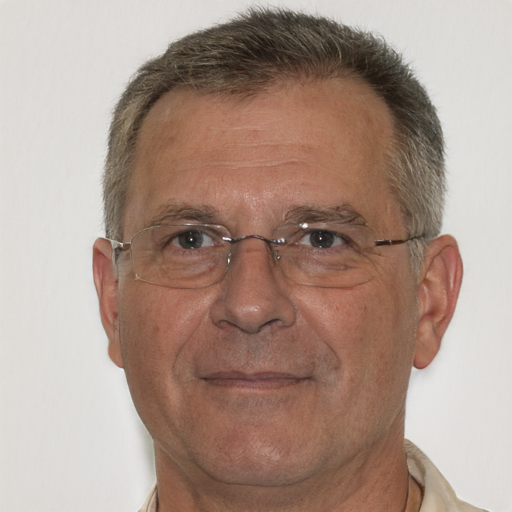

In [ ]:

img_index =  52#@param {type:"number"}
img_indexs=[img_index]
dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original


# input text description 
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |


In [ ]:
neutral='face with short hair' #@param {type:"string"}
target='face with long hair' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.4734


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

num of channels being manipulated: 439


(-0.5, 1023.5, 1023.5, -0.5)

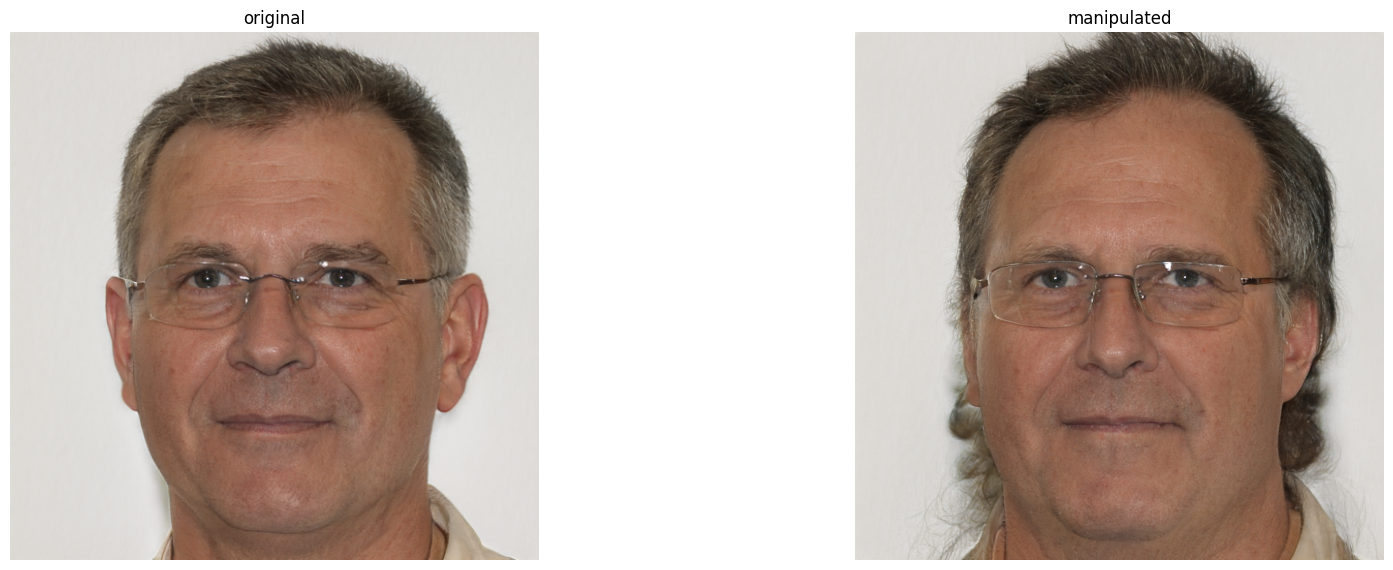

In [ ]:

#beta=0.1
#alpha=1
beta = 0.12 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 4 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')